# INTRO

The multipliers is a function of the number of bombs , number of cells clicked that were not a bomb, and house's margin per bet (in percentage)

You will see throughout these code that nº bombs is captured by the variable "r", number of spaces cleaned/cells clicked that were not a bomb by "x", house margin by "M" and number of cells by n.

The basic idea of the game is that you have n amount of cells with r bombs and n-r diamonds (or any other reward concept). You have some money you bet expecting to multiply it by a certain factor that increases progressively. If you click most diamonds you have increased your debt by a large factor, but if you clicked a bomb in the attempt of doing so the house receives your bet.


# 1. MATH

## 1.1 FINDING THE FREQUENCY FUNCTION
The function that tells you how frequent is to see the x spaces cleared. We will use them as the basis to determine if a certain movement should be more rewarded (multiplier is larger) than others relative to risk it involves.

The fundametal property of this function is for it to reward risk. That is, the more unlikely your winning chances are, the higher the reward (multiplier) should be. The inverse also applies.

So, let us first find a mathematical model (probability distribution) that captures the frequency of consecutive wins of bernoulli trials that are NOT independent.

The probability distribution $$P(x; r,n)$$, parametrized by the number of cells (n) and the number of bombs (r). x (the input of the probability distribution) refers to the number of consecutive wins in our probabilistic experiment. Note this is the frequency model of outcomes, we have yet not touched on the multiplier function (which will be built upon this).

Description of our (probabilistic) experiment:
      - there are n amount of options to choose from (cells)
      - there are r amount of bombs (cells that put you out of the game)
      - there are n-r amount of diamons (cells that multiply your bet)
      - the probability of the ith win is dependent of the prior status of the game (number of cells you had right). The likelyhood you hit a bomb is dependent on the number of prior attemps where you didnt hit one. A direct example is:  P(1; 3, 15) = 12/15 = .8, whereas for the same experiment, P(12) = 1/4 =.25

$$
P(x;n,r) = \frac{(n-r)! \cdot (n-x)!}{n! \cdot (n-r-x)!}
$$


Also note, $$n \geq x >0 $$
$$n \geq  r > 0$$

$$ 0\leq n-r-x < n-2$$

This means we **cannot** have no bombs, no movements and no cells. The third inequality is is lower-bounded by 0, this will be relevant for us computing all the possible spaces you can conver for all possibles combinations of n and r. Upper bound of n-2 just states that whatever amount of cells you have remaning they are more than the total amount of cells minus one bomb and one move (cause you assume 0 bombs and 0 moves can't happen). 

## 1.2 FINDING THE MULTIPLIER FUNCTION
The function that tells you by how much should you increase the bet. This is a function of another function (the frequency function) and the house's profit margin (in percentage).

We first fix the bet by figuring out what multiplier function is needed to make a fair bet, that is a fair where neither the bettor nor the house will make a profit.
That formula follows the following structure:

$$ E[X]_W = P(x) * [(1/P(x) -1) * b]\\
E[X]_L = (1-P(x)) * (-b)$$

W = win, L = lose.

Note b = bet amount, P(x) = frequency function of clearing out x spaces.

Let us expand the terms: 
      $$ E[X]_W = b - b*P(x) \\
      E[X]_L = -b + b*P(x)$$

Note they are the invere of each other!
Now lets just do the expected game result:
      $$ E[X]_T = E[X]_W + E[X]_L = 0 $$

T = total

This is a formula that makes it such that the expected value (the average win per round if you played long enough) will be 0 regardless of the P(x) (i.e: the status in the game you were in). 
Now, if you want to have a certain amount of profit per round (which is a percentage of b), denoted by M, by algebraic manipulation it can be shown that the multiplier should be (1-M) * 1/P(x). This will yield
an expected value of -M for the gambler. We refer to M as the house edge or house advantage (note: remember M is not a fixed number but a percentage!)

Increase M to directly influence the increase in profit, but with the tradeoff of losing proportionally user-engagement (the multipliers progress very slowly)

# 2. CODE

In [174]:
from math import factorial

import matplotlib.pyplot as plt
import pandas as pd
 

In [175]:
class MultiplierFunc():
    """
    Get the multiplier function for the given game set-up. 
    The multiplier function is a function of the frequency function and the house advantage.
    
    """
    def __init__(self, n:int, r:int, b:int = 1, M:int = .03) -> None:
        """
        Parameters:
            - n = number of cells
            - r = number of bombs in the cell
            - b = bet amount (in monetary units)
            - M = house advantage (in percentage)

        Returns:
            None
        """
        self.n = n
        self.r = r
        self.b = b
        self.M = M

    def probability_distribution(self, x:int) -> int:
        """
        Definition:
            Computes the probability of clearing x space in the given setup of the game (refer to 1.1 in the presence of doubt)
        Parameters:
            - x = number of spaces to clean
        Returns:
            probability frequency

        """
        numerator = factorial(self.n-self.r) * factorial(self.n-x)
        denominator = factorial(self.n) * factorial(self.n-self.r-x)

        return numerator / denominator # Frequency

    def frequency_table(self) -> pd.DataFrame:
        """
        Definition:
            Computes all the possible cell clean-ups scenarios.
        Parameters:
            None
        Returns:
            Pandas dataframe with the results for each possible x.

        """
        frequencies_table = dict()
        x = 0
        while self.n-self.r-x >= 0: # As long as you can make non-negative moves
            frequencies_table[x] = self.probability_distribution(x)
            x += 1

        self.results_table = pd.DataFrame(list(frequencies_table.items()), columns=["spaces_uncovered", "win_frequency"])
        self.results_table["lose_frequency"] = 1 - self.results_table["win_frequency"]
        self.results_table["payout"] = 1/self.results_table["win_frequency"] * (1-self.M) # Multiplier function
        self.results_table["win_ev"] = (self.results_table["win_frequency"] *  (self.results_table["payout"] * self.b - self.b)) 
        self.results_table["lose_ev"] = -self.b * self.results_table["lose_frequency"]
        self.results_table["EV (%)"] = self.results_table["win_ev"] + self.results_table["lose_ev"] # Refer to 1.2 in the presence of doubt

        return self.results_table.round(2) # Round up all cols' values to 2 decimals
    
    def plot_frequency(self):
        """
        Definition:
            Plots the probability distribution of the set-up and the distribution of the multipliers
        Parameters:
            None
        Returns:
            None

        """

        plt.title(f"Plot of the distribution for n:{self.n}, r:{self.r}")
        plt.plot(self.results_table["spaces_uncovered"], self.results_table["win_frequency"], label = "win frequency of x")
        plt.legend()
        plt.show()


        plt.title(f"Plot of the distribution for n:{self.n}, r:{self.r}")
        plt.plot(self.results_table["spaces_uncovered"], self.results_table["payout"], label = "multiplier at x")
        plt.legend()
        plt.show()

        return None

In [176]:
temp = MultiplierFunc(n = 25, r =2, b = 100)

results = temp.frequency_table()

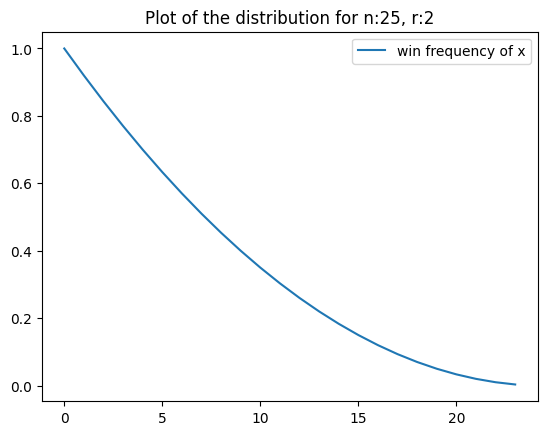

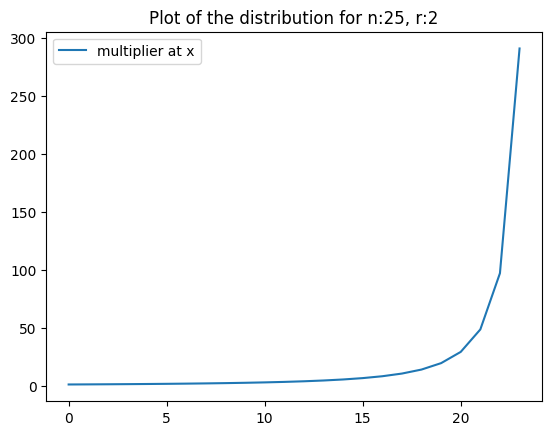

In [177]:
temp.plot_frequency()

In [178]:
results[1:] # 0 is irrelevant for current analysis

,spaces_uncovered,win_frequency,lose_frequency,payout,win_ev,lose_ev,EV (%)
1,1,0.92,0.08,1.05,5.00,-8.00,-3.0
2,2,0.84,0.16,1.15,12.67,-15.67,-3.0
3,3,0.77,0.23,1.26,20.00,-23.00,-3.0
4,4,0.70,0.30,1.39,27.00,-30.00,-3.0
5,5,0.63,0.37,1.53,33.67,-36.67,-3.0
6,6,0.57,0.43,1.70,40.00,-43.00,-3.0
7,7,0.51,0.49,1.90,46.00,-49.00,-3.0
8,8,0.45,0.55,2.14,51.67,-54.67,-3.0
9,9,0.40,0.60,2.42,57.00,-60.00,-3.0
10,10,0.35,0.65,2.77,62.00,-65.00,-3.0


Interpretation of results:

- Say you have $100,000 credit. You put 1,000 bets of $100 (b = 100) and the house has house edge of 3% (M = .03), you expect for the average net result to be -M (see the column 'EV'). That is, the final amount of the house makes is -M% of your bet! That is, the house makes a profit of b*-M on average per round assuming you play long enough. This does not directly mean at each round you lose tough. The way you reach to your final net result will oscillate throghout your way there (you may lose a lot and the suddenly win or inversely), but at the end, if you average the result out would be as if you were losing b*-M per game!

Major remark: we are using a frequentist approach for the analysis of gambling. This is, we think the probability of these events in the long run (empirical probability converges to theoretical probability as you play a sufficiently large amount of times). For that you need a extensive user-base, else this probability framework does not hold (if you only play 100 games the results will be different, for instance).

Thats alllllllllll

## REERENCES

